## Conservación de la energía

El objetivo es implementar el módulo de conservación de la energía copiando lo que hace Gabriela en C++

Consideraciones:  
* En el código de Gabriela el vector y tiene: y[1]-> radio, y[2]-> velocidad, y[3]-> temperatura (T_bc), y[4]-> nh2o, y[5]-> TLi
* Uso el modelo de Toegel (modelo 2) solamente para la parte de conductividad térmica

### Importo dependencias

In [1]:
#Importo librerías



In [2]:
#Código necesario para importar funciones de otros notebooks .ipynb

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

#Ejemplo
# from derivada_reacciones import *

In [3]:
#Importo notebooks

### Funciones

### Derivada_temperatura


importing Jupyter notebook from parametros.ipynb
1.673557692882144e-27
importing Jupyter notebook from conductividad_termica.ipynb
importing Jupyter notebook from funciones_math.ipynb
importing Jupyter notebook from funciones_qcas.ipynb
importing Jupyter notebook from presion.ipynb
Por bisección:  207343.47618162623
Por fsolve:  207343.47618162623


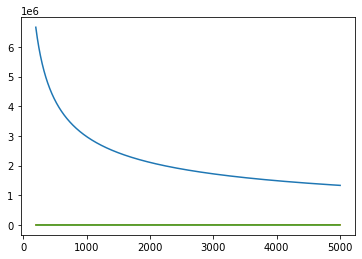

In [4]:
from parametros import alfaM, pvap0, n_species
from conductividad_termica import Conductividad1, Conductividad2
from funciones_qcas import n_tot
import numpy as np

import math
pi = math.pi

In [5]:
from parametros import var_termo

In [6]:
def dkdt(y, n, dndt, dTdt, dT2dt, dntdt):
    #Calculo dk1dt y dk2dt y los guardo en las variables dk1dt y dk2dt (son números, no vectores)

    #Calculo k1 y k2
    k1 = np.zeros(n_species)
    k2 = np.zeros(n_species)
    Conductividad1(k1)
    Conductividad2(k2)

    #Calculo dk1dt

    #Calculo dk2dt

    dk1dt=0.0

    ntot = n_tot(n)

    T_bc = y[var_termo["T_bc"]]


    for i in range(n_species):
        dk1dt=dk1dt+k2[i]*n[i]/ntot*dTdt-(k1[i]+k2[i]*T_bc)*n[i]/ntot/ntot*dntdt+(k1[i]+k2[i]*T_bc)*dndt[i]/ntot

    dk2dt=0.0

    for i in range(n_species):
        dk2dt=dk2dt+k2[i]*n[i]/ntot*dT2dt

    return dk1dt, dk2dt


In [7]:
from funciones_qcas import masa_species_Kgmol, masa_media_por_particula
from parametros import Na, sigmap
from funciones_math import Vol

In [8]:
def calcula_dntdt(dndt):
    return np.sum(dndt)

In [9]:
def calcula_dmdt(n, dndt):
    #Calcula dmdt

    #Calculo dntdt y ntot
    dntdt = calcula_dntdt(dndt)
    ntot = n_tot(n)

    dmdt = np.dot(masa_species_Kgmol, dndt)/ntot/Na
    dmdt= dmdt - masa_media_por_particula(n)/ntot*dntdt
    return dmdt


def calcula_dnpdt(y, n, dndt):
    #Calcula dnpdt

    #Asigno variables termodinámicas
    R = y[var_termo["R"]]
    v_R = y[var_termo["v_R"]]

    #Calculo el volumen
    V = Vol(R)
    #Calculo dntdt y ntot
    dntdt = calcula_dntdt(dndt)
    ntot = n_tot(n)

    dnpdt=dntdt/V-4.0*3.14159*ntot*R*R*v_R/V/V
    return dnpdt

def calcula_dlandadt(y, n, dndt):

    #Asigno variables termodinámicas
    R = y[var_termo["R"]]
    v_R = y[var_termo["v_R"]]

    #Calculo el volumen
    V = Vol(R)
    #Calculo dntdt
    dntdt = calcula_dntdt(dndt)
    ntot = n_tot(n)


    dlandadt= 4.0*3.14159*R*R*v_R/(np.sqrt(2.0)*sigmap*ntot)-V/(np.sqrt(2.0)*sigmap*ntot*ntot)*dntdt

    return dlandadt


In [10]:
from conductividad_termica import calcula_Xi

In [11]:
def calcula_dlthdt(R, v_R, k, nh2o0, ngas):

   #Calculo Xi
   Xi = calcula_Xi(k, nh2o0, ngas)

   #Calcula dlth1dt y dlth2dt
   if(v_R == 0):
      dlth1dt=v_R/pi
      dlth2dt=0.0
   else:
      if((R/pi)<(np.sqrt(R*Xi/abs(v_R)))):
         dlth1dt=v_R/pi
         dlth2dt=0.0
      else:
         dlth1dt=0.5*np.sqrt(Xi/R/abs(v_R))*v_R
         dlth2dt=-0.5*np.sqrt(R*Xi/abs(v_R)/v_R/v_R)
         #Antes:
         # dlth1dt=0.5*np.sqrt(Xi/R/v_R)*v_R
         # dlth2dt=-0.5*np.sqrt(R*Xi/v_R/v_R/v_R)
      
   return dlth1dt, dlth2dt

In [12]:
from parametros import Tinf, Rv, Cvh2o, masa_H2O_kgmol, n_reacc
from conductividad_termica import longitud_termica, Conductividad_termica_k, calculamp
from funciones_qcas import n_gas, n_tot
from parametros import ap, alfae, K, rapidez
from presion import p_g
from funciones_math import erf
from reacciones_qcas import lista_de_reacciones

from parametros import rol, cl, Pinf, sigma, mu
from parametros import var_termo
from funciones_qcas import rog
from presion import p_B

from parametros import Rg
from presion import volumen_molar, ctes_VanderWaals, volumen_molar_deriv, ctes_VanderWaals_deriv

from parametros import modelo

from parametros import n_Yasui
from conductividad_termica import landa

importing Jupyter notebook from reacciones_qcas.ipynb


In [13]:
def calcula_qppT(y, n, nh2o0):
   #Calcula qpp usando el modelo de Toegel

   #Asigno las variables termodinámicas
   T_bc = y[var_termo["T_bc"]]

   #Calculo k
   k = Conductividad_termica_k(T_bc,n)

   #Calculo el nro de partículas de gas no condensable
   ngas = n_gas(n)

   #Calculo lth
   lth = longitud_termica(y,k,nh2o0, ngas)

   # print(y,nh2o0,ngas)

   return k*(Tinf-T_bc)/lth

def calcula_qppY(y, n, nh2o0):
   #Calcula qpp usando el modelo de Yasui

   #Asigno las variables termodinámicas
   T_bc = y[var_termo["T_bc"]]
   T_bi = y[var_termo["T_bi"]]
   R = y[var_termo["R"]]
   ntot = n_tot(n)

   #Calculo k
   k = Conductividad_termica_k(T_bc,n)


   #Calculo landa
   landa_ = landa(Vol(R), sigmap, ntot)

   # print(y,nh2o0,ngas)

   return k*(T_bi-T_bc)/(n_Yasui*landa_)



In [14]:
        



def calcula_dTdt(y, n, nh2o0, dndt):
   #Calcula dTdt

   #Asigno variables termodinámicas
   R = y[var_termo["R"]]
   v_R = y[var_termo["v_R"]]
   T_bc = y[var_termo["T_bc"]]
   T_bi = y[var_termo["T_bi"]]
   mp = y[var_termo["mp"]]

   #Hago cuentas previas:
   V = Vol(R)
   pg = p_g(n, V, T_bc)

   eh2o=Cvh2o/Na*T_bi #energia llevada por una molecula que se esta evaporando o codensando

   if modelo == 1:
      #Yasui
      qpp = calcula_qppY(y, n, nh2o0)
   if modelo == 2:
      #Toegel
      qpp = calcula_qppT(y, n, nh2o0)

   #Asigno ctes:
   Mh2o = masa_H2O_kgmol
   yndisoc = 1
   CalorDifusion = 0 #AÚN NO CONSIDERÉ LA DIFUSIÓN

   #Calcula el efecto de las reacciones qcas:
   r = np.zeros(n_reacc)
   lista_de_reacciones(y, n, r)
   
   #Cambio de notación:
   #rf1 = r[0]
   #rb1 = r[1]
   #rf2 = r[2]

   if(yndisoc != 0):
      CalorDisociacion=1.0e3*V/Na*((r[0]-r[1])*498.0+     (r[2]-r[3])*428.0+(r[4]-r[5])*(-8.0)+(r[6]-r[7])*(-70.0)+      (r[8]-r[9])*436.0+(r[10]-r[11])*498.0+(r[12]-r[13])*62.0+(r[14]-r[15])*70.0+(r[16]-r[17])*(175.35)+(r[18]-r[19])*(-217.89)+(r[20]-r[21])*(290.93)+      (r[22]-r[23])*(64.32)+(r[24]-r[25])*(56.08)+(r[26]-r[27])*(128.67))
   else:
      CalorDisociacion=0.0


   #ANTES:
   # if(yndisoc != 0):
   #    CalorDisociacion=1.0e3*V/Na*((rf1-rb1)*498.0+     (rf2-rb2)*428.0+(rf3-rb3)*(-8.0)+(rf4-rb4)*(-70.0)+      (rf5-rb5)*436.0+(rf6-rb6)*498.0+(rf7-rb7)*62.0+(rf8-rb8)*70.0+      (rf9-rb9)*314.0+(rf10-rb10)*133.0+(rf11-rb11)*203.0+(rf12-rb12)*331.0+      (rf13-rb13)*150.0+(rf14-rb14)*261.0+(rf15-rb15)*(-167.0)+      (rf16-rb16)*305.0+(rf17-rb17)*193.0+(rf18-rb18)*123.0+      (rf19-rb19)*292.0+(rf20-rb20)*97.0+(rf21-rb21)*68.0+      (rf22-rb22)*159.0+(rf23-rb23)*(-15.0)+(rf24-rb24)*222.0+      (rf25-rb25)*606.0+(rf26-rb26)*(-70.0)+(rf27-rb27)*403.0+      (rf28-rb28)*143.0+(rf29-rb29)*43.0+(rf30-rb30)*98.0+      (rf31-rb31)*51.0+(rf32-rb32)*113.0+(rf33-rb33)*32.0+      (rf34-rb34)*32.0+(rf35-rb35)*(-485.0)+(rf36-rb36)*56.0+      (rf37-rb37)*467.0+(rf38-rb38)*531.0+(rf39-rb39)*207.0+      (rf40-rb40)*221.0+(rf41-rb41)*229.0+(rf42-rb42)*291.0+      (rf43-rb43)*(-13.0)+(rf44-rb44)*49.0+(rf45-rb45)*(-21.0)+      (rf46-rb46)*(175.35)+(rf47-rb47)*(-217.89)+(rf48-rb48)*(290.93)+      (rf49-rb49)*(64.32)+(rf50-rb50)*(56.08)+(rf51-rb51)*(128.67))
   # else:
   #    CalorDisociacion=0.0


   #Orden:
   # y[Nvar2+1] =H2
   # y[Nvar2+2] =H
   # y[Nvar2+3] =O
   # y[Nvar2+4] =O2
   # y[Nvar2+5] =OH
   # y[Nvar2+6] =H2O = y[4] = vapor
   # y[Nvar2+18] =H2O2
   # y[Nvar2+19] =HO2

   et1=5.0/2.0*K*T_bc+K*6325.0/(np.exp(6325.0/T_bc)-1.0)
   et2=3.0/2.0*K*T_bc
   et3=3.0/2.0*K*T_bc
   et4=5.0/2.0*K*T_bc+K*2273.0/(np.exp(2273.0/T_bc)-1.0)
   et5=5.0/2.0*K*T_bc+K*5370.0/(np.exp(5370.0/T_bc)-1.0)
   et6=6.0/2.0*K*T_bc+K*2295.0/(np.exp(2295.0/T_bc)-1.0)+K*5255.0/(np.exp(5255.0/T_bc)       -1.0)+K*5400.0/(np.exp(5400.0/T_bc)-1.0)
   # et7=3.0/2.0*K*T_bc
   # et8=5.0/2.0*K*T_bc+K*3445.0/(np.exp(3445.0/T_bc)-1.0)
   # et9=6.0/2.0*K*T_bc+K*4628.0/(np.exp(4628.0/T_bc)-1.0)+K*2152.0/(np.exp(2152.0/T_bc)       -1.0)+K*4746.0/(np.exp(4746.0/T_bc)-1.0)
   # et10=6.0/2.0*K*T_bc+K*4798.0/(np.exp(4798.0/T_bc)-1.0)+K*1366.0/(np.exp(1366.0/T_bc)        -1.0)+K*4951.0/(np.exp(4951.0/T_bc)-1.0)	  +K*4951.0/(np.exp(4951.0/T_bc)-1.0)+K*2339.0/(np.exp(2339.0/T_bc)-1.0)+          K*2339.0/(np.exp(2339.0/T_bc)-1.0)
   # et11=5.0/2.0*K*T_bc+K*4658.0/(np.exp(4658.0/T_bc)-1.0)+K*990.0/(np.exp(990.0/T_bc)-1.0)        +K*3253.0/(np.exp(3253.0/T_bc)-1.0)
   # et12=5.0/2.0*K*T_bc+K*2710.0/(np.exp(2710.0/T_bc)-1.0)
   # et13=6.0/2.0*K*T_bc+K*1878.0/(np.exp(1878.0/T_bc)-1.0)+K*1064.0/(np.exp(1064.0/T_bc)        -1.0)+K*2272.0/(np.exp(2272.0/T_bc)-1.0)
   # et14=5.0/2.0*K*T_bc+K*3098.0/(np.exp(3098.0/T_bc)-1.0)+K*822.0/(np.exp(822.0/T_bc)-1.0)        +K*1819.0/(np.exp(1819.0/T_bc)-1.0)
   # et15=5.0/2.0*K*T_bc+K*3895.0/(np.exp(3895.0/T_bc)-1.0)+K*2158.0/(np.exp(2158.0/T_bc)        -1.0)+K*2250.0/(np.exp(2250.0/T_bc)-1.0)
   # et16=5.0/2.0*K*T_bc+K*3350.0/(np.exp(3350.0/T_bc)-1.0)
   # et17=3.0/2.0*K*T_bc
   et18=6.0/2.0*K*T_bc
   et19=6.0/2.0*K*T_bc

   et_array = np.array([et1, et2, et3, et4, et5, et6, et18, et19])
   CalorTermico = -np.dot(et_array, dndt)

   # print(CalorTermico/-0.744445604930101)

   #ANTES:
   # CalorTermico=-(et1*dydt[Nvar2+1]+et2*dydt[Nvar2+2]+et3*dydt[Nvar2+3]+	       	et4*dydt[Nvar2+4]+et5*dydt[Nvar2+5]+et6*dydt[Nvar2+6]+et7*dydt[Nvar2+7]+	       	et8*dydt[Nvar2+8]+et9*dydt[Nvar2+9]+et10*dydt[Nvar2+10]+et11*dydt[Nvar2+11]+	       	et12*dydt[Nvar2+12]+et13*dydt[Nvar2+13]+et14*dydt[Nvar2+14]+et15*dydt[Nvar2+15]	       	+et16*dydt[Nvar2+16]+et17*dydt[Nvar2+17]+et18*dydt[Nvar2+18]+et19*dydt[Nvar2+19])


   det1=5.0/2.0*K+K*pow(6325.0,2.0)/(np.exp(6325.0/T_bc)-1.0)/(np.exp(6325.0/T_bc)-1.0)/T_bc/T_bc
   det2=3.0/2.0*K
   det3=3.0/2.0*K
   det4=5.0/2.0*K+K*2273.0*2273.0/(np.exp(2273.0/T_bc)-1.0)/(np.exp(2273.0/T_bc)-1.0)/T_bc/T_bc
   det5=5.0/2.0*K+K*5370.0*5370.0/(np.exp(5370.0/T_bc)-1.0)/(np.exp(5370.0/T_bc)-1.0)/T_bc/T_bc
   det6=6.0/2.0*K+K*2295.0*2295.0/(np.exp(2295.0/T_bc)-1.0)/(np.exp(2295.0/T_bc)-1.0)/T_bc/T_bc        +K*5255.0*5255.0/(np.exp(5255.0/T_bc)-1.0)/(np.exp(5255.0/T_bc)-1.0)/T_bc/T_bc+        K*5400.0*5400.0/(np.exp(5400.0/T_bc)-1.0)/(np.exp(5400.0/T_bc)-1.0)/T_bc/T_bc
   # det7=3.0/2.0*K
   # det8=5.0/2.0*K+K*3445.0*3445.0/(np.exp(3445.0/T_bc)-1.0)/(np.exp(3445.0/T_bc)-1.0)/T_bc/T_bc
   # det9=6.0/2.0*K+K*4628.0*4628.0/(np.exp(4628.0/T_bc)-1.0)/(np.exp(4628.0/T_bc)-1.0)/T_bc/T_bc        +K*2152.0*2152.0/(np.exp(2152.0/T_bc)-1.0)/(np.exp(2152.0/T_bc)-1.0)/T_bc/T_bc+        K*4746.0*4746.0/(np.exp(4746.0/T_bc)-1.0)/(np.exp(4746.0/T_bc)-1.0)/T_bc/T_bc
   # det10=6.0/2.0*K+K*4798.0*4798.0/(np.exp(4798.0/T_bc)-1.0)/(np.exp(4798.0/T_bc)-1.0)/T_bc/T_bc         +K*1366.0*1366.0/(np.exp(1366.0/T_bc)-1.0)/(np.exp(1366.0/T_bc)-1.0)/T_bc/T_bc         +K*4951.0*4951.0/(np.exp(4951.0/T_bc)-1.0)/(np.exp(4951.0/T_bc)-1.0)/T_bc/T_bc         +K*4951.0*4951.0/(np.exp(4951.0/T_bc)-1.0)/(np.exp(4951.0/T_bc)-1.0)/T_bc/T_bc+         K*2339.0*2339.0/(np.exp(2339.0/T_bc)-1.0)/(np.exp(2339.0/T_bc)-1.0)/T_bc/T_bc+         K*2339.0*2339.0/(np.exp(2339.0/T_bc)-1.0)/(np.exp(2339.0/T_bc)-1.0)/T_bc/T_bc
   # det11=5.0/2.0*K+K*4658.0*4658.0/(np.exp(4658.0/T_bc)-1.0)/(np.exp(4658.0/T_bc)-1.0)/T_bc/T_bc         +K*990.0*990.0/(np.exp(990.0/T_bc)-1.0)/(np.exp(990.0/T_bc)-1.0)/T_bc/T_bc+         K*3253.0*3253.0/(np.exp(3253.0/T_bc)-1.0)/(np.exp(3253.0/T_bc)-1.0)/T_bc/T_bc
   # det12=5.0/2.0*K+K*2710.0*2710.0/(np.exp(2710.0/T_bc)-1.0)/(np.exp(2710.0/T_bc)-1.0)/T_bc/T_bc
   # det13=6.0/2.0*K+K*1878.0*1878.0/(np.exp(1878.0/T_bc)-1.0)/(np.exp(1878.0/T_bc)-1.0)/T_bc/T_bc         +K*1064.0*1064.0/(np.exp(1064.0/T_bc)-1.0)/(np.exp(1064.0/T_bc)-1.0)/T_bc/T_bc+         K*2272.0*2272.0/(np.exp(2272.0/T_bc)-1.0)/(np.exp(2272.0/T_bc)-1.0)/T_bc/T_bc
   # det14=5.0/2.0*K+K*3098.0*3098.0/(np.exp(3098.0/T_bc)-1.0)/(np.exp(3098.0/T_bc)-1.0)/T_bc/T_bc+         K*822.0*822.0/(np.exp(822.0/T_bc)-1.0)/(np.exp(822.0/T_bc)-1.0)/T_bc/T_bc         +K*1819.0*1819.0/(np.exp(1819.0/T_bc)-1.0)/(np.exp(1819.0/T_bc)-1.0)/T_bc/T_bc
   # det15=5.0/2.0*K+K*3895.0*3895.0/(np.exp(3895.0/T_bc)-1.0)/(np.exp(3895.0/T_bc)-1.0)/T_bc/T_bc         +K*2158.0*2158.0/(np.exp(2158.0/T_bc)-1.0)/(np.exp(2158.0/T_bc)-1.0)/T_bc/T_bc         +K*2250.0*2250.0/(np.exp(2250.0/T_bc)-1.0)/(np.exp(2250.0/T_bc)-1.0)/T_bc/T_bc
   # det16=5.0/2.0*K+K*3350.0*3350.0/(np.exp(3350.0/T_bc)-1.0)/(np.exp(3350.0/T_bc)-1.0)/T_bc/T_bc
   # det17=3.0/2.0*K
   det18=6.0/2.0*K
   det19=6.0/2.0*K

   det_array = np.array([det1, det2, det3, det4, det5, det6, det18, det19])

   # if(t<=(duracion/2.0)):
   #    Pulso=Intensidad*t/(duracion/2.0)

   # else:
   #    if((t>=(duracion/2.0)) and (t<=duracion)):
   #       Pulso=(-2.0*Intensidad/duracion)*t+2.0*Intensidad
   #    else:
   #       Pulso=0.0
   Pulso = 0. #El valor de la variable Pulso no afecta en nada porque después se multiplica por cero

   # print(np.dot(det_array, n)/5.865651022892462e-13)

   # print((0.*Pulso  -  4.0*pi*R*R*v_R*pg   +   4.0*pi*R*R*mp*eh2o*Na/Mh2o   +    4.0*pi*R*R*qpp)/-11.277959686077713)
   # print(qpp, CalorDifusion, CalorDisociacion, CalorTermico, np.dot(det_array, n))
   dTdt=(0.*Pulso-4.0*pi*R*R*v_R*pg+4.0*pi*R*R*mp*eh2o*Na/Mh2o+4.0*pi*R*R*qpp         +CalorDifusion+CalorDisociacion+CalorTermico)/(np.dot(det_array, n))

   #Antes:
   # dTdt=(0.*Pulso-4.0*pi*y[1]*y[1]*y[2]*pg+4.0*pi*y[1]*y[1]*mp*eh2o*Na/Mh2o+4.0*pi*y[1]*y[1]*qpp         +CalorDifusion+CalorDisociacion+CalorTermico)/(det1*y[Nvar2+1]+det2*y[Nvar2+2]+det3*y[Nvar2+3]+         det4*y[Nvar2+4]+det5*y[Nvar2+5]+det6*y[Nvar2+6]+det7*y[Nvar2+7]+det8*y[Nvar2+8]+         det9*y[Nvar2+9]+det10*y[Nvar2+10]+det11*y[Nvar2+11]+det12*y[Nvar2+12]+         det13*y[Nvar2+13]+det14*y[Nvar2+14]+det15*y[Nvar2+15]+det16*y[Nvar2+16]+         det17*y[Nvar2+17]+det18*y[Nvar2+18]+det19*y[Nvar2+19])

   return dTdt


In [15]:

#Calculo dT2dt:
def calcula_dT2dt():
   #Calculo dT2dt. Según el código de Gabriela el resultado es cero
   return 0.0


#Calculo dpgdt:
def calcula_dpgdt(ngas, n_H2O, ntot, V, dTdt, T_bc):
   #Calcula dpgdt
   #V: vol

   #Cuentas previas:
   v = volumen_molar(V, ntot) #volumen molar
   a,b = ctes_VanderWaals(ngas, n_H2O, ntot)
   dvdt = volumen_molar_deriv()
   dadt, dbdt = ctes_VanderWaals_deriv()


   dpgdt=Rg/(v-b)*dTdt+(-Rg*T_bc/pow(v-b,2.0)+2.0*a/pow(v,3.0))*dvdt+Rg*T_bc/pow(v-b,2.0)*dbdt-1.0/v/v*dadt
   return dpgdt

#Calculo dpgdt:
def calcula_dpg2dt(ngas, n_H2O, ntot, V, dT2dt):
   #Calcula dpg2dt
   #V: vol
   #Cuentas previas
   v = volumen_molar(V, ntot) #volumen molar
   a,b = ctes_VanderWaals(ngas, n_H2O, ntot)

   dpg2dt=Rg/(v-b)*dT2dt
   return dpg2dt


#Calculo drogdt:
def calcula_drogdt(y, dndt):
   #Calcula drogdt

   #Asigno variables termodinámicas
   R = y[var_termo["R"]]
   v_R = y[var_termo["v_R"]]
   M = y[var_termo["m"]]

   #Calculo el volumen
   V = Vol(R)

   return np.dot(masa_species_Kgmol, dndt)/Na/V-M/V/V*4.0*pi*R*R*v_R


In [16]:
def calcula_mpp(y,n, nh2o0, dndt, dTdt, dT2dt, T_li, qpp, dpgdt, dpg2dt):
   #Calculo mpp1 y mpp2
   
   if(alfaM==0):
      mpp1=0.0
      mpp2=0.0
   else:
      #Asigno las variables termodinámicas
      R = y[var_termo["R"]]
      v_R = y[var_termo["v_R"]]
      T_bc = y[var_termo["T_bc"]]
      TB = y[var_termo["T_bi"]]
      mp = y[var_termo["mp"]]
      T_li = y[var_termo["T_li"]]
      T_bi = y[var_termo["T_bi"]]

      #Calculo el nro de partículas no condensable
      ngas = n_gas(n)
      #Calculo el nro total de partículas
      ntot = n_tot(n)
      #Calculo dntdt:
      dntdt = calcula_dntdt(dndt)
      V = Vol(R)
      np_=ntot/V #densidad de particulas

      pvap=pvap0
      dpvapdt=0.0

      #Calculo dk1dt y dk2dt
      dk1dt, dk2dt = dkdt(y, n, dndt, dTdt, dT2dt, dntdt)

      #Calculo dmdt
      dmdt = calcula_dmdt(n, dndt)

      #Calculo dnpdt
      dnpdt = calcula_dnpdt(y, n, dndt)

      #Calculo dlandadt
      dlandadt = calcula_dlandadt(y, n, dndt) #ESTO SE USARÍA EN EL MODELO DE YASUI

      #Calculo k
      k = Conductividad_termica_k(T_bc, n)

      #Calculo dlth1dt y dlth2dt
      dlth1dt, dlth2dt = calcula_dlthdt(R, v_R, k, nh2o0, ngas)

      if (modelo == 1):
         #Uso el modelo 1 (de Yasui)
         landa_ = landa(Vol(R), sigmap, ntot)
         dqdTB=k/n_Yasui/landa_
         dq1dt=dk1dt*(T_bi-T_bc)/n_Yasui/landa_-k/n_Yasui/landa_*dTdt-k*(T_bi-T_bc)/n_Yasui/landa_/landa_*dlandadt
         dq2dt=dk2dt*(T_bi-T_bc)/n_Yasui/landa_-k/n_Yasui/landa_*dT2dt


      if (modelo == 2):
         #Uso el modelo 2 (modelo de Toegel):

         #Calculo lth
         lth = longitud_termica(y,k,nh2o0, ngas)

         dqdTB=0.0
         dq1dt=dk1dt*(Tinf-T_bc)/lth-k/lth*dTdt-k/lth/lth*(Tinf-T_bc)*dlth1dt
         dq2dt=dk2dt*(Tinf-T_bc)/lth-k/lth*dT2dt-k/lth/lth*(Tinf-T_bc)*dlth2dt

         #Termina el uso del modelo 2

      #Calculo la masa media por partícula
      m = masa_media_por_particula(n)
      #Calculo la presión del gas
      pg = p_g(n, V, T_bc)
      #Presion parcial del vapor de agua. Se calcula con 2.2.1.6 a partir del nro de partículas de vapor (agua), el nro total de partículas y la presión total dentro de la burbuja
      pv=n[5]/ntot*pg

      dTB1dt=(T_li-(2.0-ap*alfae)/2.0/K/alfae*np.sqrt(pi/2.0/K)*(-1.0/np_/np_*dnpdt*np.sqrt(m/TB)*qpp+ 1.0/2.0/np_*np.sqrt(1.0/m/TB)*dmdt*qpp+1.0/np_*np.sqrt(m/TB)*dq1dt))/(1.0+(2.0-ap*alfae)/2.0/K/alfae*np.sqrt(pi/2.0/K)*(-1.0/2.0/np_*np.sqrt(m/TB/TB/TB)*qpp+1.0/np_*np.sqrt(m/TB)*dqdTB))

      dTB2dt=-(2.0-ap*alfae)/2.0/K/alfae*np.sqrt(pi/2.0/K)/np_*np.sqrt(m/TB)*dq2dt/(1.0+(2.0-ap*alfae)/2.0/K/alfae*np.sqrt(pi/2.0/K)*(-1.0/2.0/np_*np.sqrt(m/TB/TB/TB)*qpp+1.0/np_*np.sqrt(m/TB)*dqdTB))

      dpv1dt=(1.0-n[5]/ntot)*pg/ntot*dntdt+n[5]/ntot*dpgdt

      dpv2dt=n[5]/ntot*dpg2dt


      if(rapidez == 1):
         mpp1=alfaM/np.sqrt(2.0*pi*Rv)*(dpvapdt/np.sqrt(T_li)-0.5*pvap/pow(T_li,1.5)*T_li-1.0/np.sqrt(TB)*dpv1dt+0.5*pv/pow(TB,1.5)*dTB1dt)
         mpp2=alfaM/np.sqrt(2.0*pi*Rv)*(-1.0/np.sqrt(TB)*dpv2dt+0.5*pv/pow(TB,1.5)*dTB2dt)
      else:
         Omega=mp/pv*np.sqrt(Rv*T_bc/2.0)

         Gama=np.exp(-Omega*Omega)-Omega*np.sqrt(3.14159)*(1.0-erf(Omega))

         mpp1=alfaM/np.sqrt(2.0*pi*Rv)*(dpvapdt/np.sqrt(T_li)-0.5*pvap/pow(T_li,1.5)*T_li-mp/pv*(1.0-erf(Omega))*dpv1dt*np.sqrt(pi*Rv*T_bc/2.0/TB)+0.5*mp*(1.0-erf(Omega))*np.sqrt(pi*Rv/2.0/TB/T_bc)*dTdt-
         Gama/np.sqrt(TB)*dpv1dt+0.5*Gama*pv/pow(TB,1.5)*dTB1dt)/(1.0-alfaM/2.0*(1.0-erf(Omega))*np.sqrt(T_bc/TB))

         mpp2=alfaM/np.sqrt(2.0*pi*Rv)*(-mp/pv*(1.0-erf(Omega))*dpv2dt*np.sqrt(pi*Rv*T_bc/2.0/TB)+0.5*mp*(1.0-erf(Omega))*np.sqrt(pi*Rv/2.0/TB/T_bc)*dT2dt-Gama/np.sqrt(TB)*dpv2dt+0.5*Gama*pv/pow(TB,1.5)*dTB2dt)/(1.0-alfaM/2.0*(1.0-erf(Omega))*np.sqrt(T_bc/TB))


   return mpp1, mpp2


In [17]:
def calcula_dpB1dt(y, dndt, mpp1, dpgdt):

	#Asigno variables termodinámicas
    M = y[var_termo["m"]]
    R = y[var_termo["R"]]
    v_R = y[var_termo["v_R"]]
    mp = y[var_termo["mp"]]

    #Calculo drogdt:
    drogdt = calcula_drogdt(y, dndt)
    #Calculo rog
    rog_ = rog(M, R)

    return dpgdt+2.0*sigma*v_R/R/R+4.0*mu*v_R/R/R*(v_R-mp/rol)+ 4.0*mu/R/rol*mpp1-2.0*mp*mpp1*(1.0/rol-1.0/rog_)-mp*mp/rog_/rog_*drogdt

def calcula_dpB2dt(y, mpp2, dpg2dt):
    #Asigno variables termodinámicas
    M = y[var_termo["m"]]
    R = y[var_termo["R"]]
    mp = y[var_termo["mp"]]

    rog_ = rog(M, R)
    return dpg2dt-4.0*mu/R+4.0*mu/R/rol*mpp2-2.0*mp*mpp2*(1.0/rol-1.0/rog_)

In [18]:
def derivada_radio_energia( y, n, dydt, dndt, nh2o0):
   #Calcula la derivada de v_R

   #Consideraciones
   ps=0 #presion acustica

   #Asigno variables termodinámicas
   mp = y[var_termo["mp"]]
   v_R = y[var_termo["v_R"]]
   R = y[var_termo["R"]]
   T_li = y[var_termo["T_li"]]
   T_bc = y[var_termo["T_bc"]]

   #Cuentas previas:
   ngas = n_gas(n) #Nro de partículas de gas no condensable.
   n_H2O = n[5]
   ntot = n_tot(n)
   Volumen = Vol(R)

   # qpp = calcula_qpp(y, n, nh2o0)

   if modelo == 1:
      #Yasui
      qpp = calcula_qppY(y, n, nh2o0)
   if modelo == 2:
      #Toegel
      qpp = calcula_qppT(y, n, nh2o0)

   
   dTdt = calcula_dTdt(y, n, nh2o0, dndt)
   dT2dt = calcula_dT2dt()
   dpgdt = calcula_dpgdt(ngas, n_H2O, ntot, Volumen, dTdt, T_bc)
   dpg2dt = calcula_dpg2dt(ngas, n_H2O, ntot, Volumen, dT2dt)
   
   
   #Calculo mpp1 y mpp2
   mpp1, mpp2 = calcula_mpp(y,n, nh2o0, dndt, dTdt, dT2dt, T_li, qpp, dpgdt, dpg2dt)

   # No entiendo por qué Gabriela hace esto en el código
   # dydt[4]=dpgdt; ??

   #Asigno variables termodinámicas


   #Calculo dpB1dt y dpB2dt:
   dpB1dt = calcula_dpB1dt(y,dndt, mpp1, dpgdt)
   dpB2dt = calcula_dpB2dt(y, mpp2, dpg2dt)

   #Calculo la presion en la interfase del lado del liquido
   pB = p_B(y, n)

   dydt[var_termo["R"]] = v_R   

   dydt[var_termo["v_R"]]=(1.0/rol*(1.0+v_R/cl)*(pB-ps-Pinf)+mp/rol*(v_R+mp/2.0/rol+mp*v_R/2.0/cl/rol)-3.0/2.0*v_R*v_R*(1.0-1.0/3.0*v_R/cl+2.0*mp/3.0/cl/rol)+R/cl/rol*dpB1dt+mpp1*R/rol*(1.0-v_R/cl+mp/cl/rol))/(R*(1.0-v_R/cl+mp/cl/rol)-mpp2*R/rol*(1.0-v_R/cl+mp/cl/rol)-R/cl/rol*dpB2dt)

   dydt[var_termo["T_bc"]] = dTdt+dT2dt*dydt[var_termo["v_R"]]
   #dydt_v_R: dydt[var_termo["v_R"]]. Valor luego de aplicar la ecuación de evolución de R(t)

   return

In [19]:
#Test:
# from parametros import n_var_termo
# y = np.zeros(n_var_termo) + 100
# y[var_termo["v_R"]] = -1
# n = np.zeros(n_species) + 1e8
# dydt = y
# dndt = n
# nh2o0 = 1e8

# derivada_radio_energia( y, n, dydt, dndt, nh2o0)

NameError: name 'calcula_qpp' is not defined

In [ ]:
#Busco el error: en algún lado se está calculando sqrt(-1). Puede ser que esté en la función calcula_dTdt:
test_y = np.array([ 1.02632779e-04,  3.20977073e+01,  7.88878646e-07,  3.53797877e-01,  1.76338628e+02,  2.42244314e+02,  3.08150000e+02, -7.64387312e+02])
test_n = np.array( [1.12025643e-03, 8.66861476e+01, 2.72642953e-08, 4.13313155e-17, 8.66883874e+01, 3.14995072e+12, 2.99007493e-07, 1.79875628e-17])
test_nh2o0 = 10000000000.0
test_dndt = np.array([ 1.80507896e-05, -2.28814813e-03 , 5.88852644e-08,  2.64613333e-11, -2.27172983e-03 , 1.40821140e+18 , 9.78269681e-06,  5.77279210e-13])

  

test_dTdt = calcula_dTdt(test_y, test_n, test_nh2o0, test_dndt)
print(test_dTdt)


-25663505.119875696
